In [ ]:
!pip install torchaudio

     |████████████████████████████████| 6.7MB 8.0MB/s 


In [ ]:
import torch
import torchaudio
from IPython import display as display_
from torch import nn
import pandas as pd
%pylab inline
import torch.optim as optim
import torch.nn.functional as F
import time
import random
from google.colab import drive
drive.mount('/content/drive')

Populating the interactive namespace from numpy and matplotlib


/usr/local/lib/python3.6/dist-packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['random']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


Mounted at /content/drive


## Построение модели для распознавания речи

В задании было сказано использовать Quartznet, так что её версию мы и будем использовать, но не 5x5, а с 3 повторениями среднего блока (слои и гиперпараметры будем брать из статьи)

К сожалению, оказалось, что кроме наличия видеокарты, необходимы драйвера, программы (особенно в докере). Так что данные были выбраны из LJSpeech, при чём не все 13100 треков, а лишь малая часть

In [ ]:
metadata = pd.read_csv('/content/drive/My Drive/notebooks/data/LJSpeech-1.1/metadata.csv', sep = '|', header=None)

In [ ]:
metadata = metadata.fillna(value=-1)
with_nulls = []
for i in range(13100):
    if metadata.iloc[i][2] == -1:
        with_nulls += [i]
for i in with_nulls:
    index = metadata[1][i].find("|")
    metadata[2][i] = metadata[1][i][index + 1:]
    metadata[1][i] = metadata[1][i][:index]

In [ ]:
metadata.drop(columns=[1], inplace=True)


In [ ]:
metadata

,0,2
0,LJ001-0001,"Printing, in the only sense with which we are ..."
1,LJ001-0002,in being comparatively modern.
2,LJ001-0003,For although the Chinese took impressions from...
3,LJ001-0004,"produced the block books, which were the immed..."
4,LJ001-0005,the invention of movable metal letters in the ...
...,...,...
13095,LJ050-0274,made certain recommendations which it believes...
13096,LJ050-0275,materially improve upon the procedures in effe...
13097,LJ050-0276,"As has been pointed out, the Commission has no..."
13098,LJ050-0277,with the active cooperation of the responsible...


In [ ]:
#URL = "https://data.keithito.com/data/speech/LJSpeech-1.1.tar.bz2"
#train_dataset = torchaudio.datasets.LJSPEECH("./data", url = URL, download = True)

In [ ]:
from torch import distributions

Для CTC loss есть встроенная функция в torch, но для wer - нет

In [ ]:
def wer(predict, target):
    predict = predict.split()
    if (len(predict[-1]) > 10):
        predict[-1] = predict[-1][:10]
    target = target.split()
    d = torch.zeros((len(target)+1, len(predict)+1))
    for i in range(len(target)+1):
        d[i][0] = i
    for j in range(len(predict)+1):
        d[0][j] = j
    for i in range(1, len(target)+1):
        for j in range(1, len(predict)+1):
            if target[i-1] == predict[j-1]:
                d[i][j] = d[i-1][j-1]
            else:
                d[i][j] = min(d[i-1][j-1], d[i][j-1], d[i-1][j]) + 1
    return float(d[len(target)][len(predict)]) / len(target) * 100

Нужно реализовать аугментацию данных (хотя бы 4, но если увеличить количество данных в 4 раза, то будут снова проблемы), так что мы выберем 4 типа агументации: не менять, добавить шум из нормального распределения, изменить громкость, добавить звук адского огня на фон

In [ ]:
noise, sr = torchaudio.load('/content/drive/My Drive/notebooks/data/hellfire.wav')
noise.squeeze_().to(device)
noise = torch.cat([noise[10000:-10000]] * 9, dim=0).to(device)
noise_voler = torchaudio.transforms.Vol(0.1).to(device)
noize_level = torch.Tensor([1]).to(device)
noize_energy = torch.norm(noise).to(device)

В коде будут присутствовать и другие функции, которые будут преобразовывать данные, но они были написано мною до того, как я узнал о возможности/необходимости написать новый класс TextTransform. Потом я узнал об этом, как его писать и был написан следующий код

text_to_int и int_to_text - функции, которые переводят последовательность номеров класса в предложение и наоборот (символы в словаре - eps, space и буквы английского алфавита

data_processing пытается открыть архиф с файлами, взять оттуда аудиофайл и соответствующее ему предложение. Сигнал он преобразует в мелспектрограмму с 64 каналами, а потом использует masking. Предложения с помощью описанной ранее функции он переводит в последовательности номеров классов. Так как для ctc_loss нужны будут input_lenths и label_lengths (или target_lengths), то функция возвращает ещё и их

(некоторые строчки в коде закомментированны, так как они в основном пытались использовать cuda)

In [ ]:
from torch.utils.data import Dataset, DataLoader, random_split

In [ ]:
n = 1000
tr_part = 0.8
t_part = 0.2
train_dataset, test_dataset = random_split(
    dataset=metadata.iloc[:n].values,
    lengths=[int(n * tr_part), int(n * t_part)],
    generator=torch.Generator().manual_seed(7)
)


In [ ]:
use_cuda = torch.cuda.is_available()
torch.manual_seed(7)
device = torch.device("cuda" if use_cuda else "cpu")

In [ ]:
class TextTransform:
    def __init__(self):
        self.index = {}
        self.index[0] = ""
        self.index[1] = " "
        for i in range(2, 28):
            self.index[i] = chr(i + 95)

    def text_to_int(self, text):
        answer = []
        for symb in text:
            if symb == ' ':
                answer.append(1)
            else:
                answer.append(ord(symb) - 95)
        return answer

    def int_to_text(self, target):
        string = []
        for i in target:
            string.append(self.index[int(i)])
        return ''.join(string)

train_audio_transforms = nn.Sequential(
    torchaudio.transforms.MelSpectrogram(sample_rate=22050, n_mels=64, n_fft=1024, win_length=1024, hop_length=256).to(device),
#    torchaudio.transforms.MelSpectrogram(sample_rate=16000, n_mels=64).,
    torchaudio.transforms.FrequencyMasking(freq_mask_param=15).to(device),
    torchaudio.transforms.TimeMasking(time_mask_param=35).to(device)
)

text_transform = TextTransform()

def data_processing(data):
    spectrograms = []
    targets = []
    input_lengths = []
    targets_lengths = []
    noiser = distributions.Normal(0, 0.01)
    voler = torchaudio.transforms.Vol(2)
    for (filename, utterance) in data:
        path_to_file = "/content/drive/My Drive/notebooks/data/LJSpeech-1.1/wavs/" + filename + ".wav"
        waveform, sample_rate = torchaudio.load(path_to_file)
        waveform = waveform.to(device)
        #spectrogram = mel_transform(waveform)
        # spectrogram = spectrogram.cpu()
        #spectrogram = torch.log(spectrogram + 1e-9)

        spect = train_audio_transforms(waveform).squeeze(0).transpose(0, 1).to(device)
        voler = torchaudio.transforms.Vol(2)
        #spect_1 = train_audio_transforms(waveform + noiser.sample(waveform.size())).squeeze(0).transpose(0, 1).to(device)
        spect_2 = train_audio_transforms(voler(waveform)).squeeze(0).transpose(0, 1).to(device)
        voler = torchaudio.transforms.Vol(0.5)
        spect_1 = train_audio_transforms(voler(waveform)).squeeze(0).transpose(0, 1).to(device)
        audio_energy = torch.norm(waveform)
        alpha = (audio_energy / noize_energy) * torch.pow(10, -noize_level / 5)
        this_noise = noise[:waveform.shape[0]]
        spect_3 = train_audio_transforms(waveform + alpha * this_noise).squeeze(0).transpose(0, 1).to(device)
        specs = [spect, spect_1, spect_2, spect_3]
        spectrograms.append(specs[random.randint(0, 3)])
        #target = torch.Tensor(text_transform.text_to_int(utterance.replace("!", "").replace("?", "").replace("'", "").replace(":", "").replace(";", "").replace("(", "").replace(")", "").replace(",", "").replace(".", "").replace("\"", "").replace("-", " ").replace(";", " ").lower()))
        target = torch.Tensor(text_transform.text_to_int(utterance.replace("’", "").replace("”", "").replace("“", "").replace("è", "e").replace("ü", "u").replace("ê", "e").replace("à", "a").replace("é", "e").replace("â", "a").replace(chr(131), "").replace("\"", "").replace("!", "").replace("?", "").replace("'", "").replace(":", "").replace(";", "").replace("(", "").replace(")", "").replace(",", "").replace(".", "").replace("\"", "").replace("-", " ").replace(";", " ").lower()))
        targets.append(target)
        input_lengths.append(spect.shape[0]//2)
        targets_lengths.append(len(target))
        
    spectrograms = nn.utils.rnn.pad_sequence(spectrograms, batch_first=True).transpose(1, 2)
    targets = nn.utils.rnn.pad_sequence(targets, batch_first=True)
    return spectrograms, targets, input_lengths, targets_lengths

In [ ]:
batch = 32

In [ ]:
train_dataloader = DataLoader(
            train_dataset,
            batch_size=batch,
            collate_fn=data_processing,
            num_workers=0)

In [ ]:
test_dataloader = DataLoader(
            test_dataset,
            batch_size=batch,
            collate_fn=data_processing,
            num_workers=0)

In [ ]:
'''
batch = 4
kwargs = {'num_workers': 4, 'pin_memory': True} if use_cuda else {}
train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                            batch_size=batch,
                            shuffle=False,
                            collate_fn=lambda x: data_processing(x),
                            **kwargs)
'''

In [ ]:
class smQuartzNet(nn.Module):
    def __init__(self):
        super(smQuartzNet, self).__init__()
        
        self.start = nn.Sequential(
            nn.Conv1d(64, 256, kernel_size=[33], stride=[2], padding=(16,), groups=64, bias=False),
            nn.modules.batchnorm.BatchNorm1d(256),
            nn.ReLU(),
        )
        
        self.repeated_1 = nn.Sequential(
            nn.Conv1d(256, 256, kernel_size=[33], stride=[1], padding=(16,), groups=256, bias=False),
            nn.Conv1d(256, 256, kernel_size=(1,), stride=(1,), bias=False),
            nn.modules.batchnorm.BatchNorm1d(256, eps=0.001, momentum=0.1),
            nn.ReLU(),
            nn.Conv1d(256, 256, kernel_size=[33], stride=[1], padding=(16,), groups=256, bias=False),
            nn.Conv1d(256, 256, kernel_size=1),
            nn.modules.batchnorm.BatchNorm1d(256, eps=0.001, momentum=0.1),
            nn.ReLU(),
            nn.Conv1d(256, 256, kernel_size=[33], stride=[1], padding=(16,), groups=256, bias=False),
            nn.Conv1d(256, 256, kernel_size=1),
            nn.modules.batchnorm.BatchNorm1d(256, eps=0.001, momentum=0.1),
            nn.ReLU(),
            nn.Conv1d(256, 256, kernel_size=[33], stride=[1], padding=(16,), groups=256, bias=False),
            nn.Conv1d(256, 256, kernel_size=1),
            nn.modules.batchnorm.BatchNorm1d(256, eps=0.001, momentum=0.1),
            nn.ReLU(),
            nn.Conv1d(256, 256, kernel_size=[33], stride=[1], padding=(16,), groups=256, bias=False),
            nn.Conv1d(256, 256, kernel_size=1),
            nn.modules.batchnorm.BatchNorm1d(256, eps=0.001, momentum=0.1),
        )
        self.repeated_parallel_1 = nn.Sequential(
            nn.Conv1d(256, 256, kernel_size=(1,), stride=[1], bias=False),
            nn.modules.batchnorm.BatchNorm1d(256, eps=0.001, momentum=0.1),
        )
        self.union_1 = nn.Sequential(
            nn.ReLU(),
        )
        
        self.repeated_3 = nn.Sequential(
            nn.Conv1d(256, 256, kernel_size=[51], stride=[1], padding=(25,), groups=256, bias=False),
            nn.Conv1d(256, 512, kernel_size=(1,), stride=(1,), bias=False),
            nn.modules.batchnorm.BatchNorm1d(512, eps=0.001, momentum=0.1),
            nn.ReLU(),
            nn.Conv1d(512, 512, kernel_size=[51], stride=[1], padding=(25,), groups=512, bias=False),
            nn.Conv1d(512, 512, kernel_size=(1,), stride=(1,), bias=False),
            nn.modules.batchnorm.BatchNorm1d(512, eps=0.001, momentum=0.1),
            nn.ReLU(),
            nn.Conv1d(512, 512, kernel_size=[51], stride=[1], padding=(25,), groups=512, bias=False),
            nn.Conv1d(512, 512, kernel_size=(1,), stride=(1,), bias=False),
            nn.modules.batchnorm.BatchNorm1d(512, eps=0.001, momentum=0.1),
            nn.ReLU(),
            nn.Conv1d(512, 512, kernel_size=[51], stride=[1], padding=(25,), groups=512, bias=False),
            nn.Conv1d(512, 512, kernel_size=(1,), stride=(1,), bias=False),
            nn.modules.batchnorm.BatchNorm1d(512, eps=0.001, momentum=0.1),
            nn.ReLU(),
            nn.Conv1d(512, 512, kernel_size=[51], stride=[1], padding=(25,), groups=512, bias=False),
            nn.Conv1d(512, 512, kernel_size=(1,), stride=(1,), bias=False),
            nn.modules.batchnorm.BatchNorm1d(512, eps=0.001, momentum=0.1),
        )
        self.repeated_parallel_3 = nn.Sequential(
            nn.Conv1d(256, 512, kernel_size=(1,), stride=(1,), bias=False),
            nn.modules.batchnorm.BatchNorm1d(512, eps=0.001, momentum=0.1),
        )
        self.union_3 = nn.Sequential(
            nn.ReLU(),
        )
        
        self.repeated_5 = nn.Sequential(
            nn.Conv1d(512, 512, kernel_size=[75], stride=[1], padding=(37,), groups=256, bias=False),
            nn.Conv1d(512, 512, kernel_size=(1,), stride=(1,), bias=False),
            nn.modules.batchnorm.BatchNorm1d(512, eps=0.001, momentum=0.1),
            nn.ReLU(),
            nn.Conv1d(512, 512, kernel_size=[75], stride=[1], padding=(37,), groups=256, bias=False),
            nn.Conv1d(512, 512, kernel_size=1),
            nn.modules.batchnorm.BatchNorm1d(512, eps=0.001, momentum=0.1),
            nn.ReLU(),
            nn.Conv1d(512, 512, kernel_size=[75], stride=[1], padding=(37,), groups=256, bias=False),
            nn.Conv1d(512, 512, kernel_size=1),
            nn.modules.batchnorm.BatchNorm1d(512, eps=0.001, momentum=0.1),
            nn.ReLU(),
            nn.Conv1d(512, 512, kernel_size=[75], stride=[1], padding=(37,), groups=256, bias=False),
            nn.Conv1d(512, 512, kernel_size=1),
            nn.modules.batchnorm.BatchNorm1d(512, eps=0.001, momentum=0.1),
            nn.ReLU(),
            nn.Conv1d(512, 512, kernel_size=[75], stride=[1], padding=(37,), groups=256, bias=False),
            nn.Conv1d(512, 512, kernel_size=1),
            nn.modules.batchnorm.BatchNorm1d(512, eps=0.001, momentum=0.1),
        )
        self.repeated_parallel_5 = nn.Sequential(
            nn.Conv1d(512, 512, kernel_size=(1,), stride=[1], bias=False),
            nn.modules.batchnorm.BatchNorm1d(512, eps=0.001, momentum=0.1),
        )
        self.union_5 = nn.Sequential(
            nn.ReLU(),
        )
        
        self.near_near_end = nn.Sequential(
            nn.Conv1d(512, 512, kernel_size=87, padding=(86,)),
            nn.modules.batchnorm.BatchNorm1d(512, eps=0.001, momentum=0.1),
            nn.ReLU(),
        )
        self.near_end = nn.Sequential(
            nn.Conv1d(512, 1024, kernel_size=1),
            nn.modules.batchnorm.BatchNorm1d(1024, eps=0.001, momentum=0.1),
            nn.ReLU(),
        )
        self.end = nn.Sequential(
            nn.Conv1d(1024, 28, kernel_size=(1,), stride=(1,))
        )
        
        
    def forward(self, x):
        x = self.start(x)
        x = self.union_1(self.repeated_parallel_1(x) + self.repeated_1(x))
        x = self.union_3(self.repeated_parallel_3(x) + self.repeated_3(x))
        x = self.union_5(self.repeated_parallel_5(x) + self.repeated_5(x))
        x = self.near_near_end(x)
        x = self.near_end(x)
        return self.end(x)

In [ ]:
# продолжим обучение:
model = torch.load('/content/drive/My Drive/notebooks/data/best_train_model.pth')
model.eval()
print("we loaded the last model to continue training")

we loaded the last model to continue training


In [ ]:
model.to(device)

smQuartzNet(
  (start): Sequential(
    (0): Conv1d(64, 256, kernel_size=[33], stride=[2], padding=(16,), groups=64, bias=False)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (repeated_1): Sequential(
    (0): Conv1d(256, 256, kernel_size=[33], stride=[1], padding=(16,), groups=256, bias=False)
    (1): Conv1d(256, 256, kernel_size=(1,), stride=(1,), bias=False)
    (2): BatchNorm1d(256, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
    (3): ReLU()
    (4): Conv1d(256, 256, kernel_size=[33], stride=[1], padding=(16,), groups=256, bias=False)
    (5): Conv1d(256, 256, kernel_size=(1,), stride=(1,))
    (6): BatchNorm1d(256, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
    (7): ReLU()
    (8): Conv1d(256, 256, kernel_size=[33], stride=[1], padding=(16,), groups=256, bias=False)
    (9): Conv1d(256, 256, kernel_size=(1,), stride=(1,))
    (10): BatchNorm1d(256, eps=0.001, momentum=0.1, a

In [ ]:
model = smQuartzNet().to(device)
#model = smQuartzNet()

In [ ]:
optimizer = optim.AdamW(model.parameters(), 2e-4)

In [ ]:
criterion = nn.CTCLoss(blank=0).to(device)
#criterion = nn.CTCLoss(blank=0)

In [ ]:
!pip install python-Levenshtein

     |████████████████████████████████| 51kB 1.6MB/s 
  Created wheel for python-Levenshtein: filename=python_Levenshtein-0.12.0-cp36-cp36m-linux_x86_64.whl size=144802 sha256=d05211d17ce1e824242eece08e3439f0199dc20a039ad8efcdb685cf042b523d
  Stored in directory: /root/.cache/pip/wheels/de/c2/93/660fd5f7559049268ad2dc6d81c4e39e9e36518766eaf7e342
Successfully built python-Levenshtein


In [ ]:
import Levenshtein

In [ ]:
def cer(reference, hypothesis):
    return float(Levenshtein.distance(reference, hypothesis) / len(reference))

Для сохранения процесса обучения, мы будем запоминать значения loss, wer и выходы сети на одном из train и test предложений (правда, оказалось, что я случайно использовал не новое предложение, а высказывание из конца тренировочных данных, так что потом я просто использовал сети, которые я сохранял примерно на 5, 8, 20 и последней эпохах, так как осталось всего полнедели до дедлайна и у меня всё равно не было бы времени дообучить новую модель, которая хорошо распознаёт речь и по ней видно, как она обучается)

In [ ]:
tr_wers_history = []
tr_cers_history = []
tr_loss_history = []
t_wers_history = []
t_cers_history = []
t_loss_history = []

In [ ]:
epochs = 1

In [ ]:
import time

In [ ]:
a = time.time()
for epoch in range(epochs):
    wers = []
    cers = []
    losses = []
    for batch_idx, (spectrograms, labels, input_lengths, label_lengths) in enumerate(train_dataloader):
        spectrograms = spectrograms.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        output = model(spectrograms)
        output = F.log_softmax(output, dim=2)
        output = output.transpose(0, 1).transpose(0, 2)
        loss = criterion(output, labels, input_lengths, label_lengths)
        loss.backward()
        optimizer.step()
        losses.append(loss.item())
        out_sent = output.transpose(0, 1).transpose(2, 1)
        batch_wer = 0
        batch_cer = 0
        for i in range(batch):
            batch_wer += wer(build_sentence(out_sent[i]), text_transform.int_to_text(labels[i]))
            batch_cer += cer(build_sentence(out_sent[i]), text_transform.int_to_text(labels[i]))
        wers.append(batch_wer / batch)
        cers.append(batch_cer / batch)
        if (batch_idx % 10 == 0):
            print(time.time() - a, "batch", batch_idx)
    tr_loss_history.append(sum(losses) / len(losses))
    tr_wers_history.append(sum(wers) / len(wers))
    tr_cers_history.append(sum(cers) / len(cers))

    with torch.no_grad():
        for batch_idx, (spectrograms, labels, input_lengths, label_lengths) in enumerate(test_dataloader):
            spectrograms = spectrograms.to(device)
            labels = labels.to(device)
            output = model(spectrograms)
            output = F.log_softmax(output, dim=2)
            output = output.transpose(0, 1).transpose(0, 2)
            loss = criterion(output, labels, input_lengths, label_lengths)
            losses.append(loss.item())
            out_sent = output.transpose(0, 1).transpose(2, 1)
            batch_wer = 0
            batch_cer = 0
            for i in range(len(labels)):
                batch_wer += wer(build_sentence(out_sent[i]), text_transform.int_to_text(labels[i]))
                batch_cer += cer(build_sentence(out_sent[i]), text_transform.int_to_text(labels[i]))
            wers.append(batch_wer / batch)
            cers.append(batch_cer / batch)
    t_loss_history.append(sum(losses) / len(losses))
    t_wers_history.append(sum(wers) / len(wers))
    t_cers_history.append(sum(cers) / len(cers))
    if (min_tr_loss > tr_loss_history[-1]):
        torch.save(model, '/content/drive/My Drive/notebooks/data/best_train_model.pth')
        min_tr_loss = t_loss_history[-1]
    if (min_t_loss > t_loss_history[-1]):
        torch.save(model, '/content/drive/My Drive/notebooks/data/best_test_model.pth')
        min_t_loss = t_loss_history[-1]
    print(time.time() - a, "seconds for the first", epoch + 1, "epochs")

46.104379415512085 batch 0
513.7889065742493 batch 10
979.5835018157959 batch 20


In [ ]:
#min_tr_loss = tr_loss_history[0]
#min_t_loss = t_loss_history[0]

#torch.save(model, '/content/drive/My Drive/notebooks/data/best_train_model.pth')
#torch.save(model, '/content/drive/My Drive/notebooks/data/best_test_model.pth')

Следующий график был построен для маленького числа файлов (n = 100)

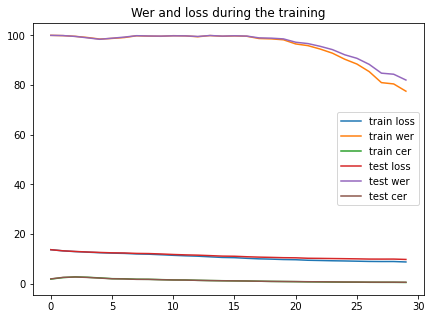

In [ ]:
figsize(7, 5)
plt.plot(range(len(tr_loss_history)), tr_loss_history)
plt.plot(range(len(tr_wers_history)), tr_wers_history)
plt.plot(range(len(tr_cers_history)), tr_cers_history)
plt.plot(range(len(t_loss_history)), t_loss_history)
plt.plot(range(len(t_wers_history)), t_wers_history)
plt.plot(range(len(t_cers_history)), t_cers_history)
plt.title("Wer and loss during the training")
plt.legend(['train loss', 'train wer', 'train cer', 'test loss', 'test wer', 'test cer'])
plt.show()

Следующий график на модели на 1000 файлах

In [ ]:
figsize(7, 5)
plt.plot(range(len(tr_loss_history)), tr_loss_history)
plt.plot(range(len(tr_wers_history)), tr_wers_history)
#plt.plot(range(len(tr_cers_history)), tr_cers_history)
plt.plot(range(len(t_loss_history)), t_loss_history)
plt.plot(range(len(t_wers_history)), t_wers_history)
#plt.plot(range(len(t_cers_history)), t_cers_history)
plt.title("Wer and loss during the training")
plt.legend(['train loss', 'train wer', 'test loss', 'test wer'])
plt.show()

NameError: ignored

In [ ]:
'''
print(tr_loss_history)
print(tr_cers_history)
print(tr_wers_history)
print(t_loss_history)
print(t_cers_history)
print(t_wers_history)
'''

[13.15267546335856, 12.786006317138671, 12.655752334594727, 12.59014133453369, 12.515908088684082, 12.484817237854005, 12.44714958190918, 12.406231231689453]
[2.5029910778266373, 2.6903921032726212, 2.7750395405994084, 2.8109642535976214, 2.5899070462463865, 2.672736010395462, 2.527183116633788, 2.4465349269160344]
[100.46229284310266, 99.63766937159451, 99.95160382574082, 99.99375, 99.34866640874125, 97.66456383942122, 98.20251887937042, 98.7211682576183]
[13.04106778286873, 12.757796734571457, 12.637541800737381, 12.57711723446846, 12.506350696086884, 12.479750990867615, 12.442561775445938, 12.407240569591522]
[2.593631866571034, 2.59769531508278, 2.683739325203895, 2.7040157578278734, 2.512730783912914, 2.5972563313074533, 2.4805713009061146, 2.3968149264939074]
[100.37281680895377, 97.37317919655821, 97.61844048886002, 97.55161009987779, 96.56395877497334, 95.2551673816543, 95.65315021516145, 96.54886764006308]


In [ ]:
'''
tr_loss_history = [13.15267546335856, 12.786006317138671, 12.655752334594727, 12.59014133453369, 12.515908088684082, 12.484817237854005, 12.44714958190918, 12.406231231689453]
tr_cers_history = [2.5029910778266373, 2.6903921032726212, 2.7750395405994084, 2.8109642535976214, 2.5899070462463865, 2.672736010395462, 2.527183116633788, 2.4465349269160344]
tr_wers_history = [100.46229284310266, 99.63766937159451, 99.95160382574082, 99.99375, 99.34866640874125, 97.66456383942122, 98.20251887937042, 98.7211682576183]
t_loss_history = [13.04106778286873, 12.757796734571457, 12.637541800737381, 12.57711723446846, 12.506350696086884, 12.479750990867615, 12.442561775445938, 12.407240569591522]
t_cers_history = [2.593631866571034, 2.59769531508278, 2.683739325203895, 2.7040157578278734, 2.512730783912914, 2.5972563313074533, 2.4805713009061146, 2.3968149264939074]
t_wers_history = [100.37281680895377, 97.37317919655821, 97.61844048886002, 97.55161009987779, 96.56395877497334, 95.2551673816543, 95.65315021516145, 96.54886764006308]
tr_loss_history += [12.369123725891113]
tr_cers_history += [2.4137555197853806]
tr_wers_history += [99.6011199602257]
t_loss_history += [12.378914475440979]
t_cers_history += [2.361868317366043]
t_wers_history += [97.02277694458945]
tr_loss_history += [12.345686950683593, 12.31416633605957, 12.290589904785156, 12.265057640075684, 12.235067710876464, 12.197931365966797]
tr_cers_history += [2.2510948789939724, 2.2040868860829788, 2.0880220089240997, 2.108570929314989, 1.977652864467918, 1.9785284519681472]
tr_wers_history += [99.08301932216831, 99.42956804615773, 99.50728829627047, 99.31388245615308, 99.52857820158262, 99.45723566319424]
t_loss_history += [12.357251673936844, 12.330729901790619, 12.315782576799393, 12.29245212674141, 12.270951956510544, 12.240727126598358]
t_cers_history += [2.2049711746455656, 2.139991060346584, 2.0480532150892454, 2.0576412541610756, 1.946738768770392, 1.9152668298739584]
t_wers_history += [96.84627101817043, 97.0682339413584, 96.94770048667274, 96.94655477137286, 96.911600342993, 97.03566978239121]
'''

Чтобы использовать модель для предсказания можно использовать код из следующей ячейки

In [ ]:
wav, sr = torchaudio.load('/content/drive/My Drive/notebooks/data/LJSpeech-1.1/wavs/LJ001-0001.wav')
spectr = [train_audio_transforms(wav.to(device)).squeeze(0).transpose(0, 1)]
spectrs = nn.utils.rnn.pad_sequence(spectr, batch_first=True).transpose(1, 2)
out = model(spectrs)
out = F.log_softmax(out, dim=2)
out = out.transpose(0, 1).transpose(0, 2)
out = out.transpose(0, 1).transpose(2, 1)
print(build_sentence(out[0]))

otwtgthe mbwhihgh wabpvlcmpdfusogigomlgnvmprykxpugxqzqjzjzj


Настоящее предложение звучит так:

In [ ]:
def viz(wav):
    figsize(20, 5)
    plot(wav)
    plt.show()
    display_.display(display_.Audio(wav, rate=22050, normalize=False))

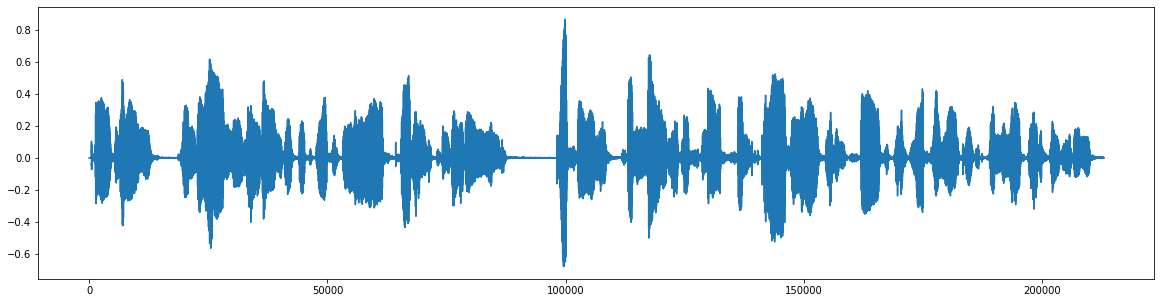

In [ ]:
wav, sr = torchaudio.load('data/LJSpeech-1.1/wavs/LJ001-0001.wav')
wav.squeeze_()
viz(wav)

In [ ]:
metadata[1][0]

'Printing, in the only sense with which we are at present concerned, differs from most if not from all the arts and crafts represented in the Exhibition'

In [ ]:
import matplotlib.pyplot as plt

На семинаре было сказано, что beam_search надстраивается сверху на сеть, так что сейчас напишем свою версию и используем: вдруг он улучшит предсказания

In [ ]:
def main_symb(probs):
    i = 0
    maxim = probs[i]
    for j in range(1, len(probs)):
        if (probs[j] > maxim):
            maxim = probs[j]
            i = j
    if i == 0:
        return '`', maxim, i
    elif i == 1:
        return ' ', maxim, i
    else:
        return chr(95 + i), float(maxim), i

In [ ]:
def beam_search(predicts, beams = 3, sentences = [[1, ""]]):
    best = []
    probs = predicts[:, 0]
    probs += 1 - min(probs)
    probs = probs / probs.sum()
    t_answer = []
    for i in range(beams):
        s, p, ind = main_symb(probs)
        probs[ind] = 0
        best.append([s, p])
    if sentences[0][1] == "":
        for i in range(beams):
            t_answer.append([sentences[0][0] * best[i][1], sentences[0][1] + best[i][0]])
    else:
        for i in range(beams):
            for j in range(len(sentences)):
                if (sentences[j][1][-1] == '`'):
                    string = sentences[j][1][:-1] + best[i][0]
                elif (sentences[j][1][-1] == best[i][0]):
                    string = sentences[j][1]
                else:
                    string = sentences[j][1] + best[i][0]
                prob = sentences[j][0] * best[i][1]
                t_answer.append([prob, string])
    t_answer = sorted(t_answer, reverse = True)
    answer = [t_answer[0]]
    for i in range(1, len(t_answer)):
        answer = sorted(answer, reverse = True)
        added = False
        for j in range(len(answer)):
            if (answer[j][1] == t_answer[i][1]):
                answer[j][0] += t_answer[i][0]
                added = True
                break
        if (added == False and len(answer) < beams):
            answer.append(t_answer[i])
        elif (added == False and t_answer[i][0] > answer[-1][0]):
            answer[-1] = t_answer[i]
    answer = sorted(answer, reverse = True)
    if predicts.shape[1] == 1:
        return answer[0][1]
    else:
        if predicts.shape[1] % 10 == 0:
            print(sorted(answer, reverse = True))
        return beam_search(predicts[:, 1:], beams, sorted(answer, reverse = True))
    

In [ ]:
def max_symb(probs):
    i = 0
    maxim = probs[i]
    for j in range(1, len(probs)):
        if (probs[j] > maxim):
            maxim = probs[j]
            i = j
    if i == 0:
        return '`'
    elif i == 1:
        return ' '
    else:
        return chr(95 + i)

def build_sentence(probs):
    answer = max_symb(probs[:, 0])
    for i in range(1, probs.shape[1]):
        symb = max_symb(probs[:, i])
        if (answer[-1] != symb):
            if (answer[-1] == '`'):
                answer = answer[:-1] + symb
            else:
                answer = answer + symb
    return answer

In [ ]:
torch.save(model, 'data/best_final_model.pth')

Использовать мою модель можно с весами из 'best_final_model.pth'